In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import pickle
# import faiss
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from tqdm import tqdm
import torch.nn.functional as F
from collections import defaultdict, Counter
import random
import torch
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from sklearn.manifold import TSNE
import umap
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset

# VQVAE Implementation

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# with open("pkl files/chunks.pkl", "rb") as f:
#     chunks = pickle.load(f)

with open("/content/drive/MyDrive/chunks.pkl", "rb") as f:
    chunks = pickle.load(f)

In [13]:
# Importing models
from vqmodel import *

In [14]:
# Dataframe to tensor transition
images = []

for df in chunks:
    # df['ch'] is a Series of 80 columns; each item is a list of 200 values
    # Create a (200, 80) NumPy array (transpose is needed)
    matrix = np.stack(df['PWR_ch1'].to_list(), axis=1)  # shape: (200, 80)
    images.append(matrix)

# Convert the whole thing to numpy because making tensors from a list of arrays
# is extremely slow
images_array = np.array(images)


In [15]:
# Convert to torch tensor and add batch + channel dimensions
data_tensor = torch.tensor(images_array, dtype=torch.float32)  # (B, 200, 80)
data_tensor = data_tensor.unsqueeze(1)  # (B, 1, 200, 80)

In [16]:
from torch.utils.data import DataLoader

dataset = ChunkImageDataset(chunks)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
model = VQVAE(in_channels=1)

for batch in loader:
    print(batch.shape)  # (8, 1, 200, 80)
    outputs = model(batch)
    break  # for test

torch.Size([8, 1, 200, 30])


In [17]:
from sklearn.model_selection import train_test_split

# 1. First split: 80% train, 20% temp
train_chunks, temp_chunks = train_test_split(
    chunks, test_size=0.2, random_state=2555304
)

In [18]:
# 2. Split temp into 10% val, 10% test
val_chunks, test_chunks = train_test_split(
    temp_chunks, test_size=0.5, random_state=2555304
)

In [19]:
# Check counts
print(f"Train: {len(train_chunks)}")
print(f"Validation: {len(val_chunks)}")
print(f"Test: {len(test_chunks)}")

Train: 5147
Validation: 643
Test: 644


In [20]:
from torch.utils.data import DataLoader

# Wrap into datasets
train_dataset = ChunkImageDataset(train_chunks)
val_dataset = ChunkImageDataset(val_chunks)
test_dataset = ChunkImageDataset(test_chunks)

In [21]:
# Loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

# Model Training

In [28]:
def train_vqvae(model, train_loader, val_loader, optimizer, device="cuda", epochs=500):
    import os, math
    import numpy as np
    import torch
    import torch.nn.functional as F
    import matplotlib.pyplot as plt

    os.makedirs("output_images", exist_ok=True)
    model.to(device)

    # Metric histories
    train_losses, val_losses = [], []
    recon_losses, vq_losses = [], []
    cb_losses, cm_losses = [], []
    code_usages, zq_stds = [], []
    perplexities = []

    K = getattr(model.quantizer, "num_embeddings", None)

    for epoch in range(1, epochs + 1):
        model.train()
        total_loss = recon_total = cb_total = cm_total = vq_total = 0.0

        # Per-epoch code usage (counts over all tokens this epoch)
        code_counts = None if K is None else np.zeros(K, dtype=np.int64)
        zq_std_accum = []

        # ---------- Train ----------
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad(set_to_none=True)

            out = model(batch)
            out["total_loss"].backward()
            optimizer.step()

            bs = batch.size(0)
            total_loss += out["total_loss"].item() * bs
            recon_total += out["recon_loss"].item() * bs
            cb_total    += out["codebook_loss"].item() * bs
            cm_total    += out["commitment_loss"].item() * bs
            vq_total    += out["vq_loss"].item() * bs

            # Track z_q dispersion
            if "z_q" in out:
                zq_std_accum.append(float(out["z_q"].std().item()))

            # Update code usage counts safely
            idx = out.get("indices", None)
            if (idx is not None) and (K is not None):
                flat = idx.detach().cpu().view(-1).numpy()
                code_counts += np.bincount(flat, minlength=K)

        # ---------- Validate ----------
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                out = model(batch)
                # fallback: if your forward returns recon loss directly, fine; else compute MSE
                val_loss += F.mse_loss(out["recon_x"], batch).item() * batch.size(0)

        # ---------- Epoch aggregates ----------
        n_train = len(train_loader.dataset)
        n_val   = len(val_loader.dataset)

        train_losses.append(total_loss / n_train)
        val_losses.append(val_loss / n_val)
        recon_losses.append(recon_total / n_train)
        cb_losses.append(cb_total / n_train)
        cm_losses.append(cm_total / n_train)
        vq_losses.append(vq_total / n_train)
        zq_stds.append(float(np.mean(zq_std_accum)) if zq_std_accum else float("nan"))

        # Code usage + perplexity from counts (no concatenation)
        if (code_counts is not None) and code_counts.sum() > 0:
            code_usages.append(int((code_counts > 0).sum()))
            p = code_counts / code_counts.sum()
            nz = p > 0
            H = float(-(p[nz] * np.log(p[nz])).sum())
            perplexities.append(float(math.exp(H)))
        else:
            code_usages.append(0)
            perplexities.append(float("nan"))

        print(f"[Epoch {epoch}] "
              f"Train {train_losses[-1]:.4f} | Val {val_losses[-1]:.4f} | "
              f"Recon {recon_losses[-1]:.4f} | VQ {vq_losses[-1]:.4f} | "
              f"Codes Used {code_usages[-1]} | Perp {perplexities[-1]:.2f} | "
              f"z_q std {zq_stds[-1]:.6f}")

    # ---------- Plots ----------
    epochs_range = range(1, epochs + 1)
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 4, 1); plt.plot(epochs_range, train_losses, label='Train'); plt.plot(epochs_range, val_losses, label='Val'); plt.title("Total Loss"); plt.legend()
    plt.subplot(2, 4, 2); plt.plot(epochs_range, recon_losses, label='Recon'); plt.title("Reconstruction"); plt.legend()
    plt.subplot(2, 4, 3); plt.plot(epochs_range, cb_losses, label='Codebook'); plt.title("Codebook Loss"); plt.legend()
    plt.subplot(2, 4, 4); plt.plot(epochs_range, cm_losses, label='Commit'); plt.title("Commitment Loss"); plt.legend()
    plt.subplot(2, 4, 5); plt.plot(epochs_range, vq_losses, label='VQ'); plt.title("VQ Loss"); plt.legend()
    plt.subplot(2, 4, 6); plt.plot(epochs_range, code_usages, label='Unique Codes'); plt.title("Code Usage"); plt.legend()
    plt.subplot(2, 4, 7); plt.plot(epochs_range, perplexities, label="Perplexity"); plt.title("Codebook Perplexity"); plt.xlabel("Epoch"); plt.ylabel("Perp"); plt.legend(); plt.grid(True)

    plt.tight_layout()
    plt.savefig("output_images/Training_graphs.png")
    plt.show()


[Epoch 1] Train 0.6392 | Val 0.4740 | Recon 0.6334 | VQ 0.0059 | Codes Used 227 | Perp 80.69 | z_q std 0.561018
[Epoch 2] Train 0.4036 | Val 0.3342 | Recon 0.3936 | VQ 0.0100 | Codes Used 233 | Perp 112.31 | z_q std 0.730714
[Epoch 3] Train 0.3038 | Val 0.2668 | Recon 0.2890 | VQ 0.0149 | Codes Used 285 | Perp 139.88 | z_q std 0.901957
[Epoch 4] Train 0.2596 | Val 0.2286 | Recon 0.2430 | VQ 0.0166 | Codes Used 324 | Perp 162.78 | z_q std 1.009749
[Epoch 5] Train 0.2315 | Val 0.2040 | Recon 0.2098 | VQ 0.0217 | Codes Used 363 | Perp 183.47 | z_q std 1.104269
[Epoch 6] Train 0.2158 | Val 0.1940 | Recon 0.1915 | VQ 0.0242 | Codes Used 394 | Perp 195.24 | z_q std 1.198044
[Epoch 7] Train 0.2074 | Val 0.1811 | Recon 0.1815 | VQ 0.0259 | Codes Used 422 | Perp 206.94 | z_q std 1.253911
[Epoch 8] Train 0.2014 | Val 0.1770 | Recon 0.1740 | VQ 0.0274 | Codes Used 441 | Perp 211.81 | z_q std 1.314177
[Epoch 9] Train 0.1984 | Val 0.1724 | Recon 0.1703 | VQ 0.0282 | Codes Used 463 | Perp 225.73 | z

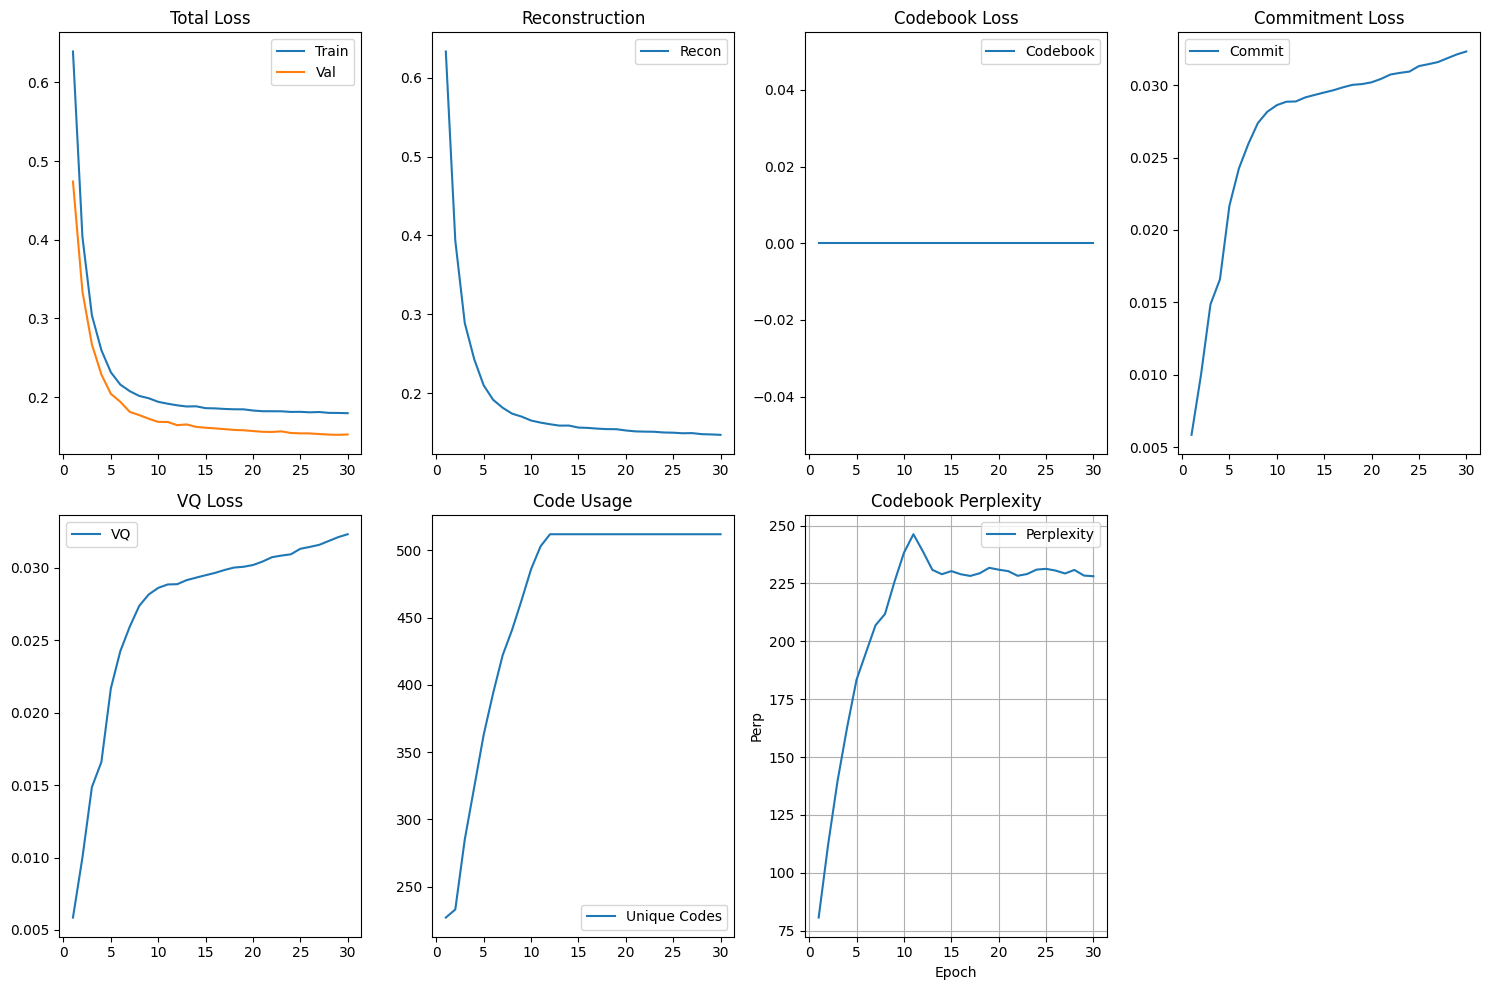

In [30]:
model = VQVAE(beta=0.45)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_vqvae(model, train_loader, val_loader, optimizer, epochs=30)

In [31]:
torch.save(model.state_dict(), "model pt files/vqvae_model.pth")
torch.save(model.state_dict(), "/content/drive/MyDrive/vqvae_model.pth")

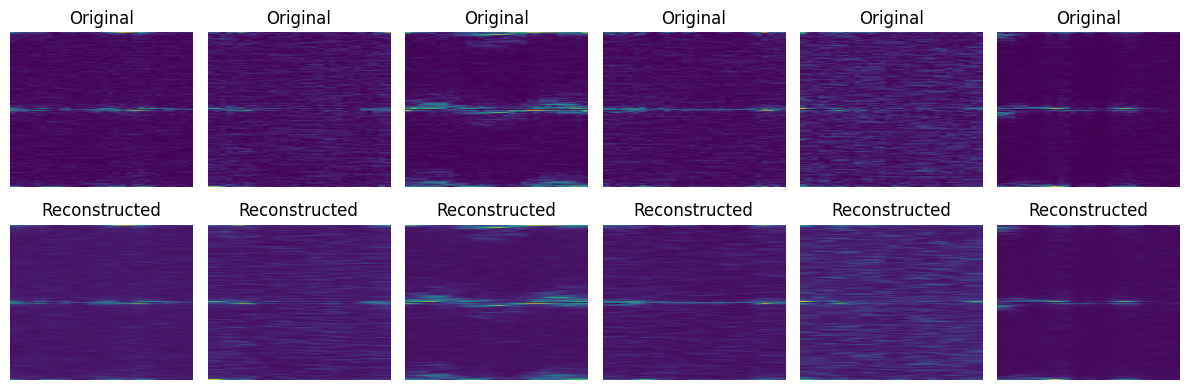

In [32]:
# Define the model again (same config as used during training)
model = VQVAE(in_channels=1, embedding_dim=128, num_embeddings=512, beta=0.5)
model.load_state_dict(torch.load("model pt files/vqvae_model.pth"))
model.eval()
model.to("cuda" if torch.cuda.is_available() else "cpu")

# Get a batch from the validation loader
device = next(model.parameters()).device
val_iter = iter(test_loader)
batch = next(val_iter).to(device)

# Run the model
with torch.no_grad():
    output = model(batch)
    recon = output["recon_x"]

# Plot original and reconstructed images
n = min(6, batch.size(0))  # number of samples to show
plt.figure(figsize=(12, 4))
for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(batch[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Original")
    plt.axis('off')

    # Reconstructed
    plt.subplot(2, n, i + 1 + n)
    plt.imshow(recon[i][0].cpu().numpy(), cmap='viridis', aspect='auto')
    plt.title("Reconstructed")
    plt.axis('off')

plt.tight_layout()
plt.savefig("output_images/ReconstructionExamples.png")
plt.show()

# Average Latent Space Representation

In [33]:
def validate_chunks(chunks):
    for i, chunk in enumerate(chunks):
        if chunk['exp_no'].nunique() != 1 or chunk['activity'].nunique() != 1:
            raise ValueError(f"Chunk {i} contains multiple exp_no or activity values.")
    print("All chunks have consistent 'exp_no' and 'activity'.")

In [34]:
def sample_chunks_by_activity(chunks, n_per_activity=5, seed=2555304):
    random.seed(seed)
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    sampled_chunks = []
    for activity, chunk_list in activity_map.items():
        sampled = random.sample(chunk_list, min(n_per_activity, len(chunk_list)))
        sampled_chunks.extend(sampled)
    return sampled_chunks

In [35]:
def chunk_to_image(chunk, channel='PWR_ch1'):
    # Safely reshape each (200,) array to (200, 1), then stack horizontally
    images = [arr.reshape(200, 1) for arr in chunk[channel].values]
    return np.hstack(images)  # Result: (200, 80)

In [36]:
def plot_chunks_as_images(chunks, cmap='inferno'):
    activity_map = defaultdict(list)
    for chunk in chunks:
        activity = chunk['activity'].iloc[0]
        activity_map[activity].append(chunk)

    for activity, chunk_list in activity_map.items():
        n = len(chunk_list)
        cols = 5
        rows = int(np.ceil(n / cols))
        plt.figure(figsize=(4 * cols, 3 * rows))

        for i, chunk in enumerate(chunk_list):
            img = chunk_to_image(chunk)
            plt.subplot(rows, cols, i + 1)
            plt.imshow(img, aspect='auto', cmap=cmap, origin='lower')
            plt.title(f"{activity} #{i+1}")
            plt.axis('off')

        plt.suptitle(f"Activity: {activity}", fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig("output_images/Sampled Images.png")
        plt.show()


In [37]:
# Validate all chunks
validate_chunks(chunks)

All chunks have consistent 'exp_no' and 'activity'.


In [38]:
# Sample 5 chunks per activity
sampled_chunks = sample_chunks_by_activity(chunks, n_per_activity=5)

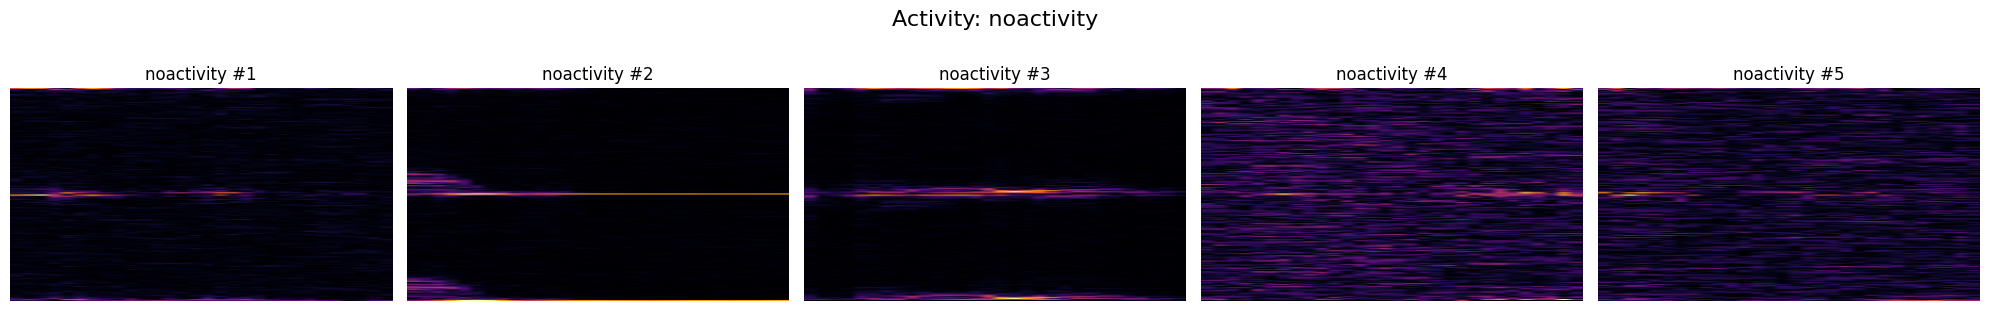

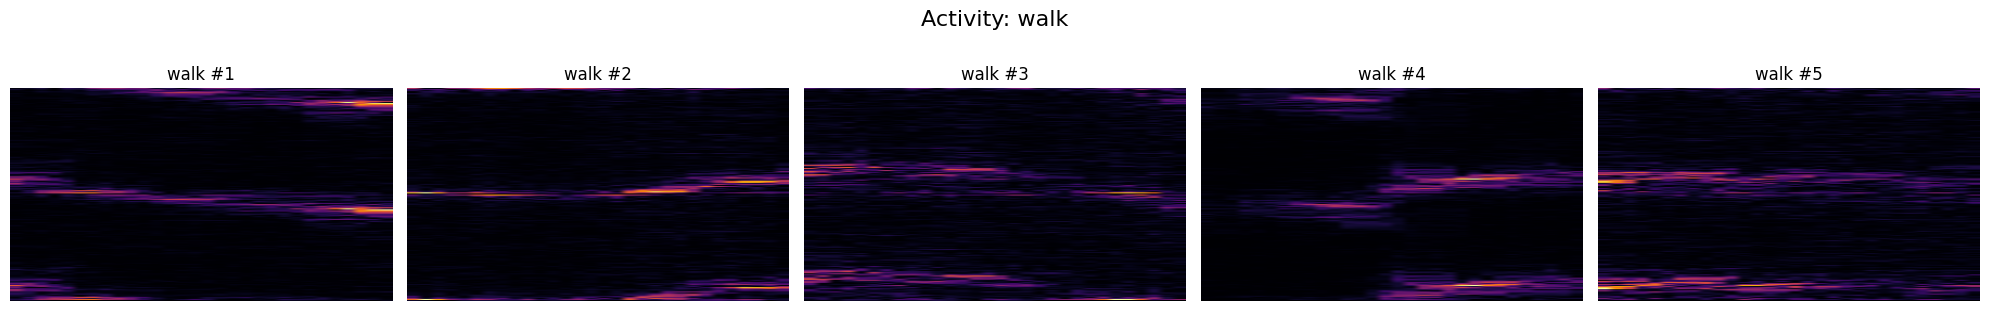

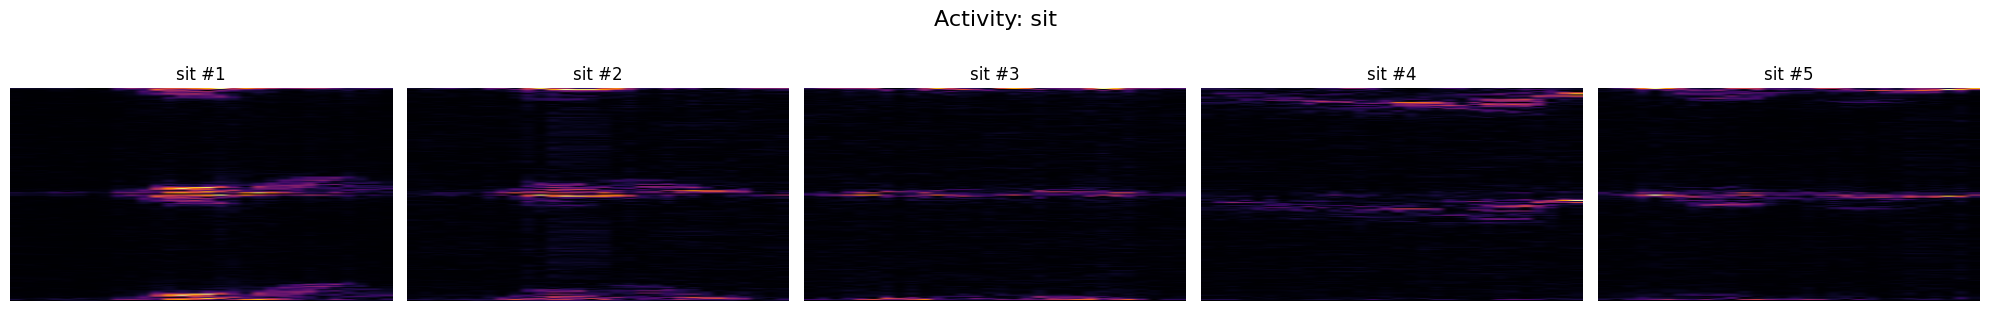

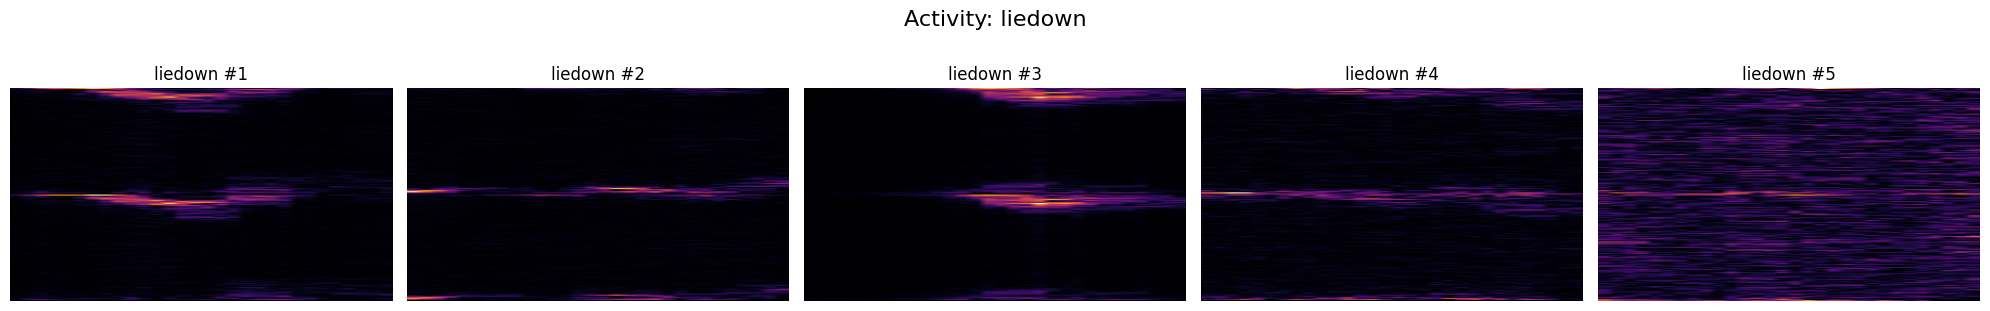

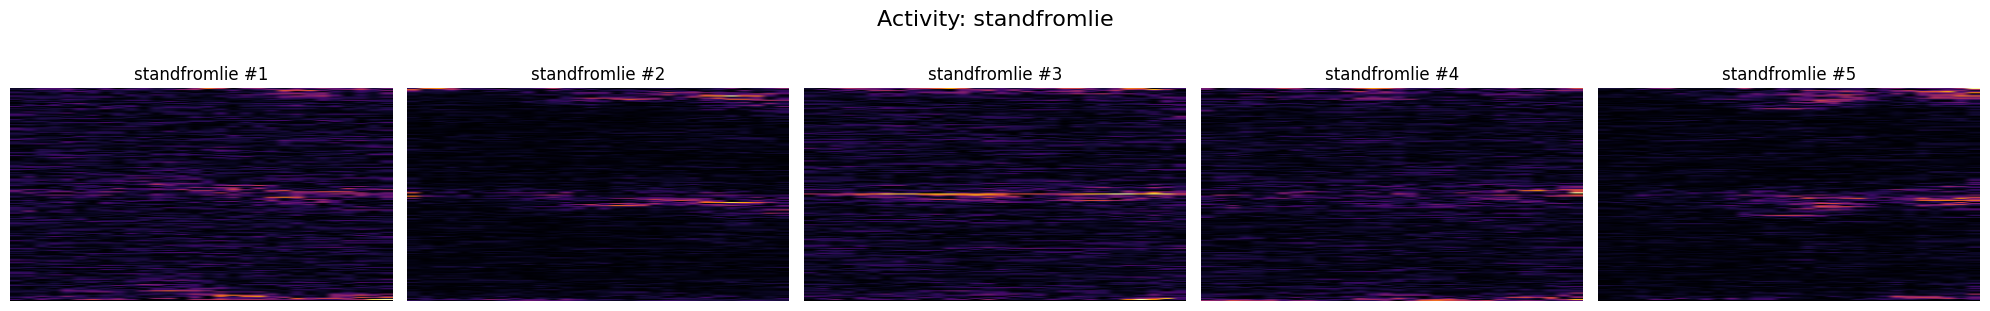

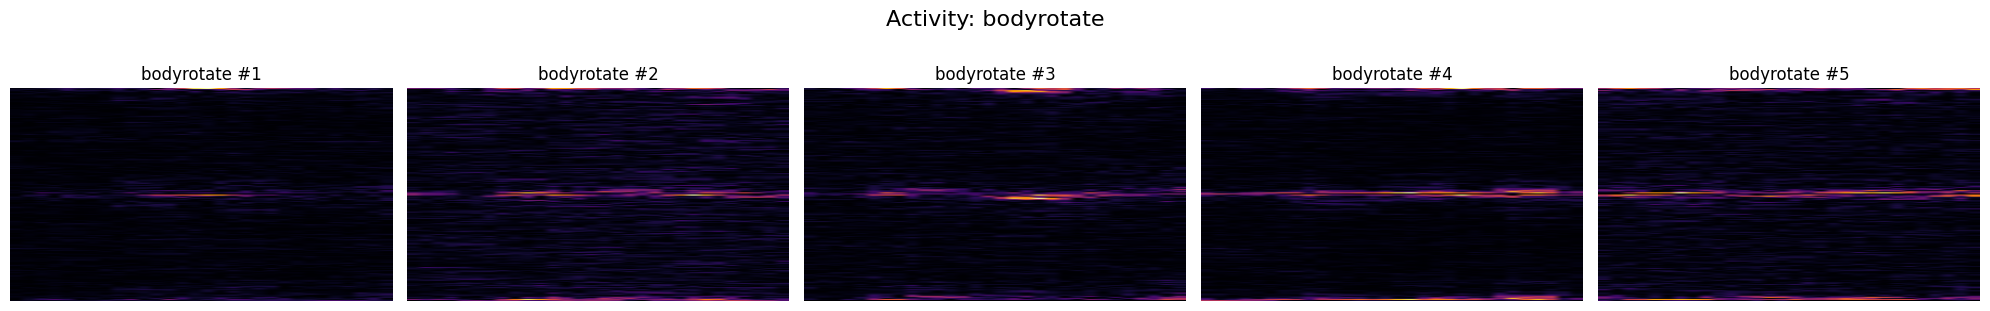

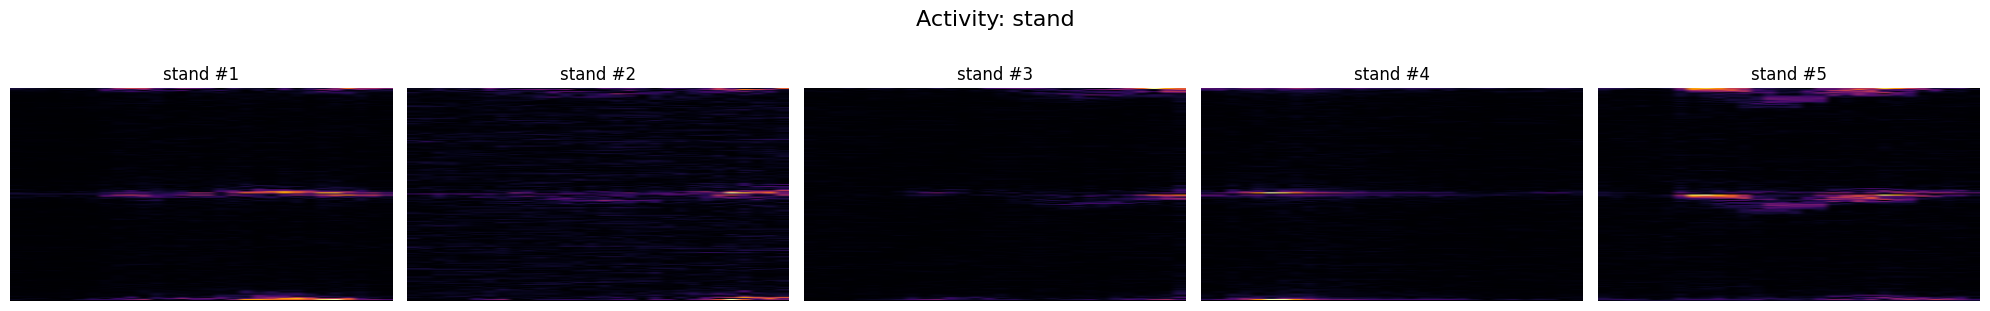

In [39]:
# Plot as images
plot_chunks_as_images(sampled_chunks)

In [40]:
def count_chunks_by_activity(chunks):
    activity_counts = Counter(chunk['activity'].iloc[0] for chunk in chunks)
    return activity_counts

In [41]:
activity_counts = count_chunks_by_activity(chunks)

for activity, count in activity_counts.items():
    print(f"{activity}: {count} chunks")

noactivity: 4048 chunks
walk: 1149 chunks
sit: 54 chunks
liedown: 194 chunks
standfromlie: 189 chunks
bodyrotate: 763 chunks
stand: 37 chunks


In [42]:
def filter_out_class(chunks, class_to_remove='noactivity'):
    return [chunk for chunk in chunks if chunk['activity'].iloc[0] != class_to_remove]

chunks = filter_out_class(chunks, class_to_remove='noactivity')

In [43]:
# Build matrix of chunk-level features
features = []
labels = []

for chunk in chunks:
    # Convert each list in 'PWR_ch1' column into a single vector
    # e.g., mean over rows, or flatten if consistent shape
    power_data = np.stack(chunk['PWR_ch1'].values)  # shape: (chunk_size, signal_len)
    pooled = power_data.mean(axis=0)                # average across rows
    features.append(pooled)

    activity = chunk['activity'].iloc[0]
    labels.append(activity)

X = np.stack(features)
y = np.array(labels)


In [44]:
# Oversample
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=2555304)
X, y = ros.fit_resample(X, y)

In [45]:
# Optional: PCA first to reduce dimensionality before t-SNE
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=2555304, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_pca)


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [46]:
umap_model = umap.UMAP(n_components=2, random_state=2555304)
X_umap = umap_model.fit_transform(X_pca)

/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


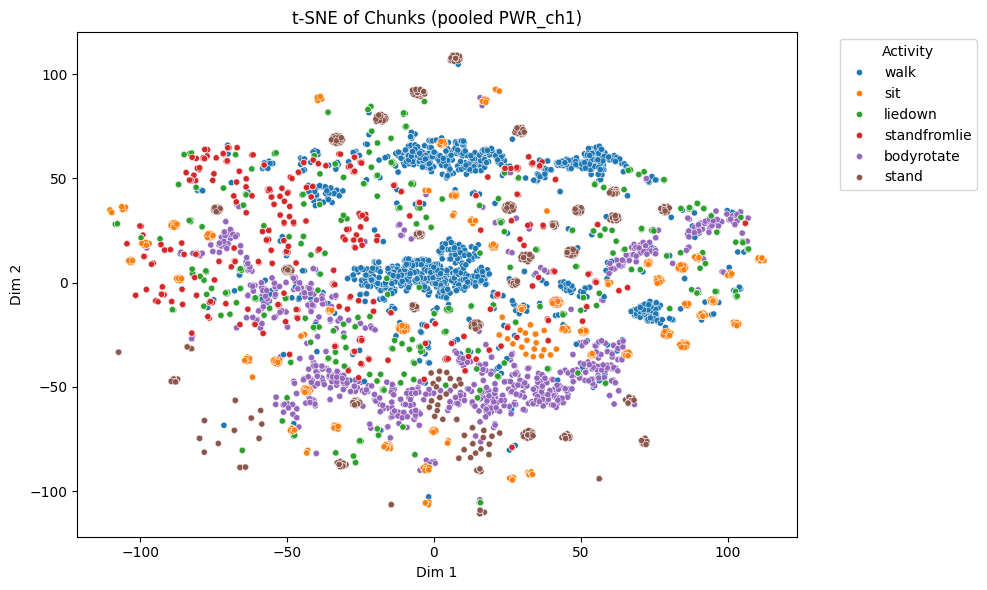

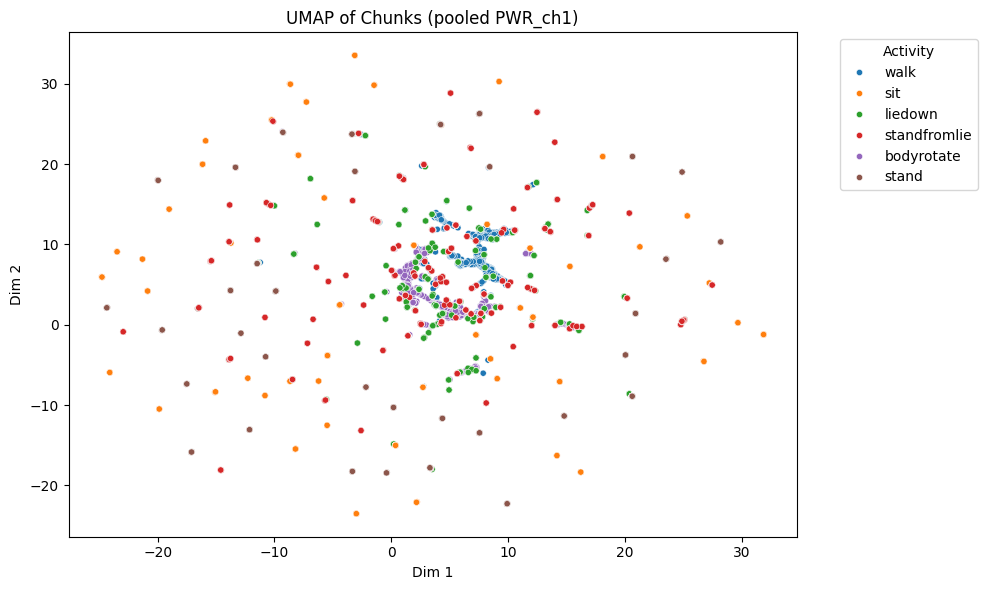

In [47]:
def plot_embedding(X_embedded, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', s=20)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"output_images/{title}.png")
    plt.show()

# t-SNE plot
plot_embedding(X_tsne, y, "t-SNE of Chunks (pooled PWR_ch1)")

# UMAP plot
plot_embedding(X_umap, y, "UMAP of Chunks (pooled PWR_ch1)")


In [48]:
chunk_tensors = []
chunk_labels = []

for chunk in chunks:
    # shape: (chunk_size, signal_length)
    arr = np.stack(chunk['PWR_ch1'].values)
    tensor = torch.tensor(arr, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # (1, 1, H, W)
    chunk_tensors.append(tensor)
    chunk_labels.append(chunk['activity'].iloc[0])

In [49]:
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

ze_list = []
zq_list = []

with torch.no_grad():
    for tensor in chunk_tensors:
        tensor = tensor.to(device)
        z_e = model.encoder(tensor)            # (1, C, H', W')
        z_q, *_ = model.quantizer(z_e)         # (1, C, H', W')

        ze_flat = z_e.squeeze(0).cpu().numpy().reshape(-1)  # flatten to 1D
        zq_flat = z_q.squeeze(0).cpu().numpy().reshape(-1)

        ze_list.append(ze_flat)
        zq_list.append(zq_flat)


In [50]:
ze_matrix = np.stack(ze_list)
zq_matrix = np.stack(zq_list)

# PCA to reduce noise
print("Running PCA...")
pca = PCA(n_components=30)
ze_pca = pca.fit_transform(ze_matrix)
zq_pca = pca.fit_transform(zq_matrix)

# t-SNE
print("Running t-SNE...")
tsne = TSNE(n_components=2, random_state=2555304, perplexity=30)
ze_tsne = tsne.fit_transform(ze_pca)
zq_tsne = tsne.fit_transform(zq_pca)

# UMAP
print("Running UMAP...")
umap_model = umap.UMAP(n_components=2, random_state=2555304)
ze_umap = umap_model.fit_transform(ze_pca)
zq_umap = umap_model.fit_transform(zq_pca)


Running PCA...
Running t-SNE...
Running UMAP...


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


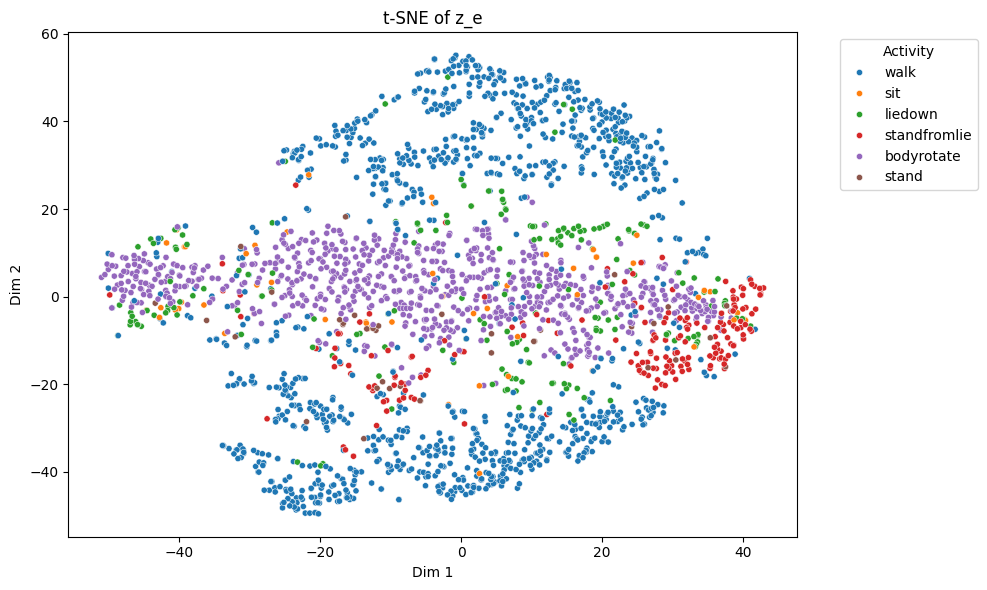

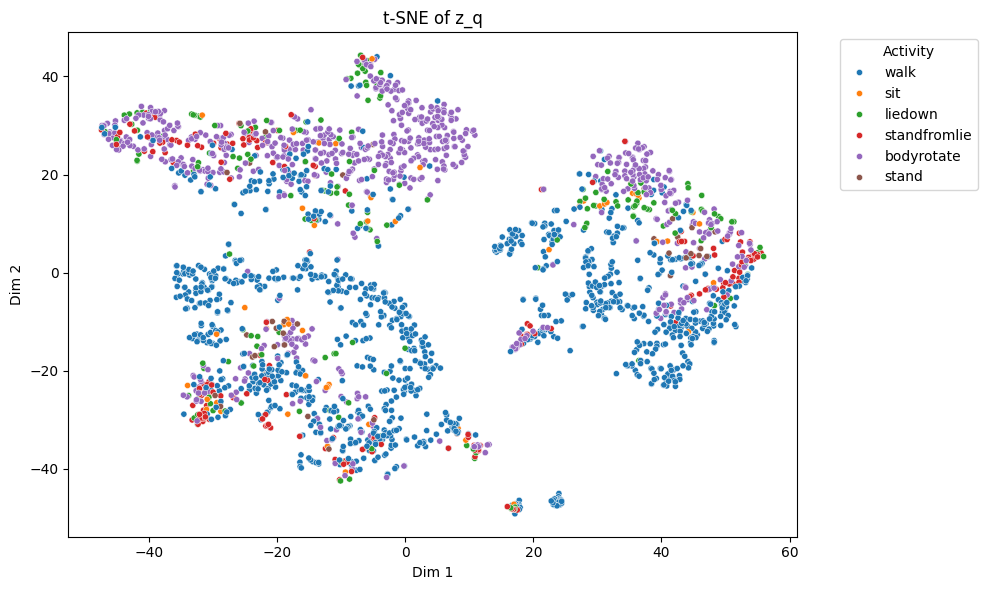

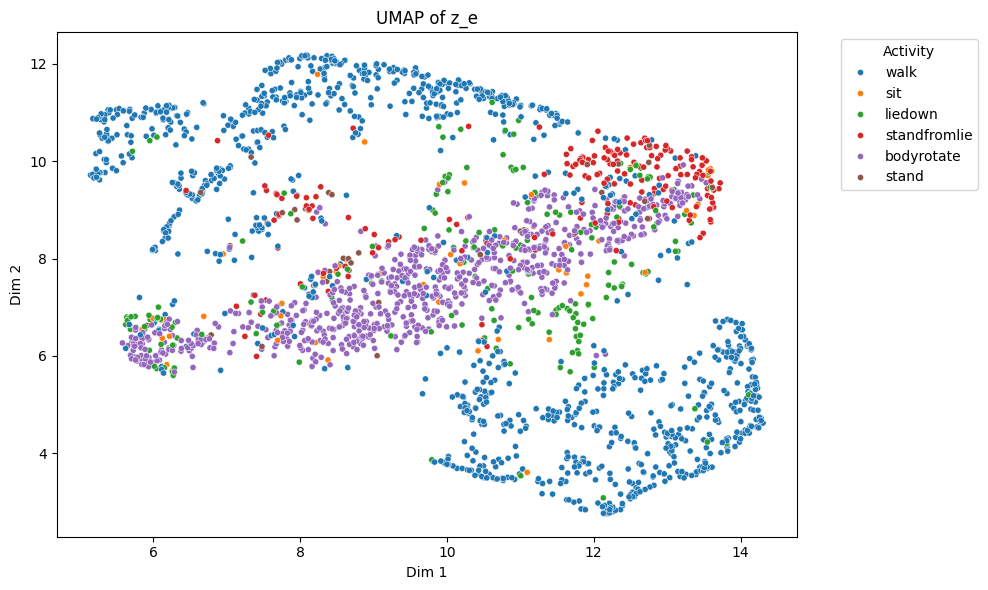

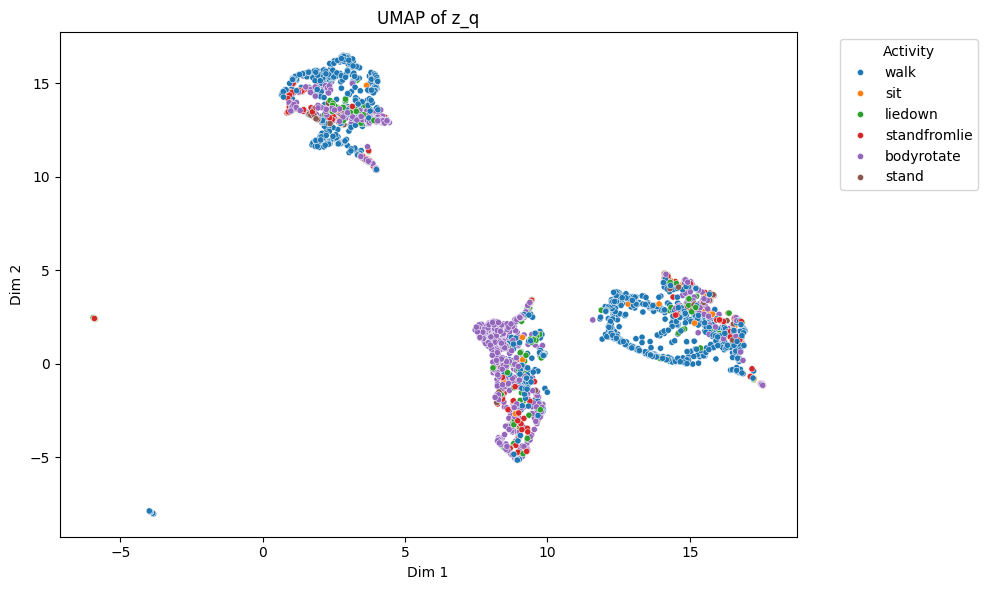

In [51]:
def plot_2d(embedding, labels, title):
    import matplotlib.pyplot as plt
    import seaborn as sns

    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=embedding[:, 0], y=embedding[:, 1], hue=labels, palette='tab10', s=20)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"output_images/{title}.png")
    plt.show()

# Plot t-SNE
plot_2d(ze_tsne, chunk_labels, "t-SNE of z_e")
plot_2d(zq_tsne, chunk_labels, "t-SNE of z_q")

# Plot UMAP
plot_2d(ze_umap, chunk_labels, "UMAP of z_e")
plot_2d(zq_umap, chunk_labels, "UMAP of z_q")


In [52]:
index_histograms = []
labels = []

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

with torch.no_grad():
    for chunk in chunks:
        arr = np.stack(chunk['PWR_ch1'].values)
        tensor = torch.tensor(arr, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        z_e = model.encoder(tensor)
        _, _, _, _, indices = model.quantizer(z_e)  # indices: shape (B * H * W)

        # Convert to CPU and numpy
        indices = indices.cpu().numpy()

        # Histogram of indices
        hist, _ = np.histogram(indices, bins=np.arange(model.quantizer.num_embeddings + 1))
        index_histograms.append(hist)
        labels.append(chunk['activity'].iloc[0])


In [53]:
X = np.stack(index_histograms)

# PCA
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X)

# t-SNE
tsne = TSNE(n_components=2, random_state=2555304, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

# UMAP
umap_model = umap.UMAP(n_components=2, random_state=2555304)
X_umap = umap_model.fit_transform(X_pca)


/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


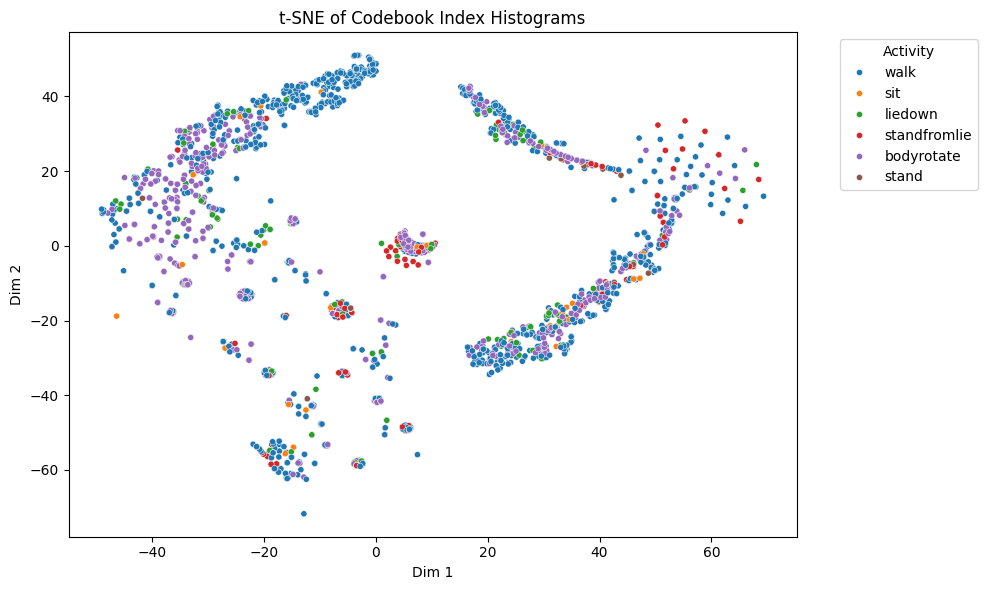

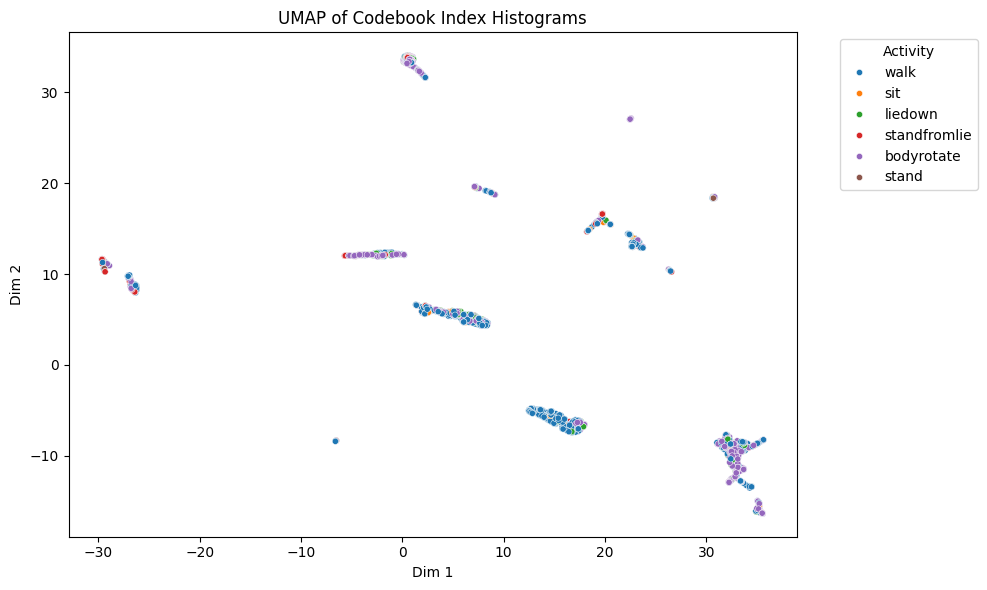

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_2d(X_embedded, labels, title):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:, 1], hue=labels, palette='tab10', s=20)
    plt.title(title)
    plt.xlabel("Dim 1")
    plt.ylabel("Dim 2")
    plt.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.savefig(f"output_images/{title}.png")
    plt.show()

plot_2d(X_tsne, labels, "t-SNE of Codebook Index Histograms")
plot_2d(X_umap, labels, "UMAP of Codebook Index Histograms")

# KNN